In [16]:
import sys
import os
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scikit_posthocs import posthoc_nemenyi
import pandas as pd

import seaborn as sns
import joblib

from kan import KAN
from sklearn.metrics import mean_squared_error


sys.path.append("../../")

from analysis_functions import (
    test_after_opt,
    split_transform_one_comp_cv,
    opener,
    KANModelTrainTest,
    clean_input_array,
)


In [17]:
# Load data
X_stress_components_new = opener(
    "X_stress_components_new_components", path_import="../../new_components_resources/"
)
y_stress_components_new = opener(
    "y_stress_components_new_components", path_import="../../new_components_resources/"
)

print(X_stress_components_new.shape)

component_num = 0
X_current = X_stress_components_new[component_num]
y_current = y_stress_components_new[component_num]

../../new_components_resources//X_stress_components_new_components.pkl
../../new_components_resources//y_stress_components_new_components.pkl
(3, 1597, 5)


Загрузка KAN

In [18]:
model = KAN.loadckpt(
    "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/ml_core_kan_components/testing_final_models/saved_models/0/model/"
    + "0.1"
)
kan_model = KANModelTrainTest(False)
kan_model.model = model
kan_model.create_train_val_test(
    X_current,
    y_current,
)

X_test, y_test, _, _, train_list_X, train_list_y = split_transform_one_comp_cv(
    X_current, y_current, n_splits=1
)
X_test, y_test = clean_input_array(X_test, y_test)
my_dataset = kan_model.create_dataset(
    kan_model.train_set_X[0],
    kan_model.train_set_y[0],
    kan_model.cur_X_test,
    kan_model.cur_y_test,
)

# Получаем предсказания

predictions = model(my_dataset["test_input"]).detach().numpy()
truth = my_dataset["test_label"].detach().numpy()
kan_errors = np.sqrt(np.mean((truth - predictions) ** 2, axis=1))
kan_errors = (y_test - predictions.ravel()) ** 2


2025-05-11 22:12:40,676 - INFO - Using device: cpu


In [19]:
kan_errors

array([1929.2573177 , 1273.52792369,  734.56471368, ...,    3.98727966,
         25.60092084, 1038.29607191])

Загрузка MLP

In [20]:
input_size = 6
output_size = 1

best_mlp_params = {
    "n_layers": 2,
    "n_units_0": 53,
    "n_units_1": 97,
    "activation": "tanh",
    "learning_rate": 0.0033923538523987205,
    "batch_size": 128,
    "optimizer": "Adam",
    "max_epochs": 204,
}

# Instantiate the model with the same architecture
# You'll need to import your model class, e.g., from gpu_optuna import MLPNetwork
# This assumes MLPNetwork is defined in gpu_optuna and takes these params
# You might need to adjust this based on your actual MLPNetwork class definition
from gpu_optuna import (
    MLPNetwork,
    predict_with_model,
)

mlp_model = MLPNetwork(
    layer_sizes=[input_size]
    + [best_mlp_params[f"n_units_{i}"] for i in range(best_mlp_params["n_layers"])]
    + [output_size],
    activation=best_mlp_params["activation"],
)
model_path = "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/ml_core_mlp_compoments/testing_final_models/models/mlp_regressor_model_0.pth"
# Load the saved state dictionary
mlp_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode (important for inference)
mlp_model.eval()

print(f"Model loaded from {model_path} and set to evaluation mode.")

# Получаем предсказания


# Get training data
X_train = train_list_X[0]
y_train = train_list_y[0]

# Clean input arrays (handle NaNs, etc.)
X_train, y_train = clean_input_array(X_train, y_train)
X_test, y_test = clean_input_array(X_test, y_test)

# Convert to PyTorch tensors
device = "cpu"
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1)).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1)).to(device)

# Create standardization parameters
mean = X_train_tensor.mean(0, keepdim=True)
std = X_train_tensor.std(0, unbiased=False, keepdim=True)
std[std == 0] = 1  # prevent division by zero

predictions = predict_with_model(mlp_model, X_test, mean, std)

mlp_errors = np.sqrt(
    np.mean((y_test.reshape(-1, 1) - predictions) ** 2, axis=1)
)

mlp_errors = (y_test - predictions.ravel()) ** 2

# mlp_errors = mean_squared_error(
#     y_test.reshape(1, -1), predictions, multioutput="raw_values"
# )


Model loaded from /Users/i.grebenkin/pythonProjects/учеба/wire_drawing/ml_core_mlp_compoments/testing_final_models/models/mlp_regressor_model_0.pth and set to evaluation mode.


In [21]:
mlp_errors

array([750.07219819, 474.53816678, 319.39121494, ...,  71.25671503,
        71.27506671, 125.8416715 ])

Загрузка Decision Tree

In [22]:
decision_tree_model = joblib.load(
    "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/simple_ml_models/new_components/0/decision_tree/best_decision_tree_model.pkl"
)

# Predict using the best model
cur_y_pred_best = decision_tree_model.predict(X_test)

# Evaluate the best model
dt_errors = mean_squared_error(
    y_test.reshape(1, -1), cur_y_pred_best.reshape(1, -1), multioutput="raw_values"
)

In [23]:
dt_errors

array([0.01809698, 0.64541139, 0.06650209, ..., 0.01408969, 0.87095556,
       5.97949209])

Загрузка Gradient Boosting

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
import pickle

# Load the best model
gradient_boosting_model = joblib.load(
    "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/simple_ml_models/new_components/0/gradient_boosting/best_gradient_boosting_model.pkl"
)

# Predict using the best model
cur_y_pred_best = gradient_boosting_model.predict(X_test)
# Evaluate the best model
# gb_errors = np.sqrt(
#     np.mean((y_test.reshape(1, -1) - cur_y_pred_best.reshape(1, -1)) ** 2, axis=0)
# )
gb_errors = mean_squared_error(
    y_test.reshape(1, -1), cur_y_pred_best.reshape(1, -1), multioutput="raw_values"
)



In [25]:
gb_errors

array([7.38510288, 6.96479728, 0.39119904, ..., 1.71430952, 0.10339897,
       1.11065613])

In [26]:
# Соберите ошибки всех доступных моделей в DataFrame
errors_df = pd.DataFrame({
    'KAN': kan_errors,
    'MLP': mlp_errors,
    'Decision Tree': dt_errors,
    'Gradient Boosting': gb_errors
})

# Проведение теста Фридмана
friedman_stat, p_value = stats.friedmanchisquare(
    errors_df['KAN'], 
    errors_df['MLP'], 
    errors_df['Decision Tree'],
    errors_df['Gradient Boosting']
)

print(f"Статистика Фридмана: {friedman_stat:.4f}")
print(f"p-значение: {p_value:.6f}")

Статистика Фридмана: 4306.1672
p-значение: 0.000000


In [27]:
# save errors_df
errors_df.to_csv(
    "errors_df_2.csv",
    index=False,
)

## Тест Неменьи (Post-hoc анализ)

Если тест Фридмана показывает статистически значимую разницу между моделями (p-значение < 0.05), необходимо выполнить post-hoc анализ для определения, какие конкретные пары моделей отличаются друг от друга. Для этого используется тест Неменьи.

Результаты теста Неменьи (p-значения для попарных сравнений):
     0    1             2             3
0  1.0  0.0  0.000000e+00  0.000000e+00
1  0.0  1.0  0.000000e+00  0.000000e+00
2  0.0  0.0  1.000000e+00  2.313705e-13
3  0.0  0.0  2.313705e-13  1.000000e+00


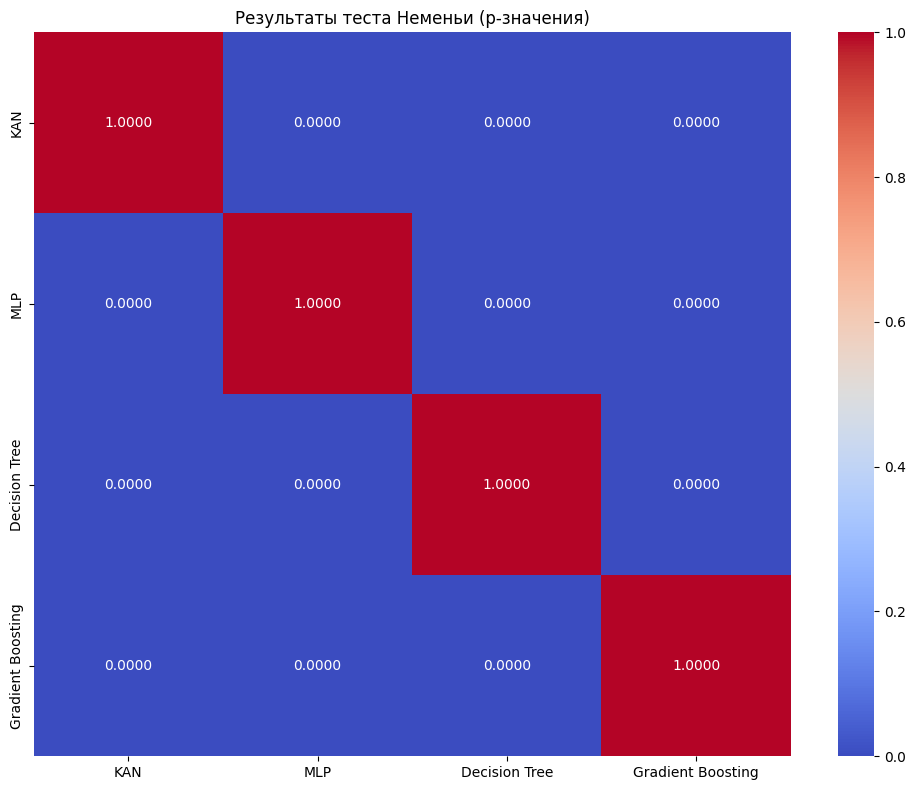

In [28]:
from scikit_posthocs import posthoc_nemenyi_friedman

# Преобразуем DataFrame в массив numpy для использования с posthoc_nemenyi_friedman
# Данные должны иметь форму: строки - блоки (тестовые образцы), столбцы - группы (модели)
errors_array = errors_df.values

# Проведение теста Неменьи
nemenyi_result = posthoc_nemenyi_friedman(errors_array)

print("Результаты теста Неменьи (p-значения для попарных сравнений):")
print(nemenyi_result)

# Визуализация результатов теста Неменьи с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_result, annot=True, cmap='coolwarm', fmt='.4f', 
            xticklabels=errors_df.columns, yticklabels=errors_df.columns)
plt.title('Результаты теста Неменьи (p-значения)')
plt.tight_layout()
plt.show()

In [29]:
# Интерпретация результатов
alpha = 0.05  # Уровень значимости

# Создаем DataFrame для хранения результатов сравнения
comparison_results = pd.DataFrame(index=errors_df.columns, columns=errors_df.columns)

# Заполняем DataFrame результатами
for i in range(len(errors_df.columns)):
    for j in range(len(errors_df.columns)):
        model_i = errors_df.columns[i]
        model_j = errors_df.columns[j]
        p_value = nemenyi_result.iloc[i, j]
        
        if i == j:  # Диагональ - сравнение модели с самой собой
            comparison_results.loc[model_i, model_j] = '-'
        else:
            if p_value < alpha:
                comparison_results.loc[model_i, model_j] = f'Значимо (p={p_value:.4f})'
            else:
                comparison_results.loc[model_i, model_j] = f'Не значимо (p={p_value:.4f})'

print("Интерпретация попарных сравнений (уровень значимости α=0.05):")
comparison_results

Интерпретация попарных сравнений (уровень значимости α=0.05):


,KAN,MLP,Decision Tree,Gradient Boosting
KAN,-,Значимо (p=0.0000),Значимо (p=0.0000),Значимо (p=0.0000)
MLP,Значимо (p=0.0000),-,Значимо (p=0.0000),Значимо (p=0.0000)
Decision Tree,Значимо (p=0.0000),Значимо (p=0.0000),-,Значимо (p=0.0000)
Gradient Boosting,Значимо (p=0.0000),Значимо (p=0.0000),Значимо (p=0.0000),-


## Интерпретация результатов

При интерпретации результатов теста Неменьи:

1. **p-значение < 0.05** означает, что между двумя моделями существует статистически значимое различие в точности (ошибке предсказания).

2. **p-значение ≥ 0.05** означает, что нет статистически значимых доказательств различия в точности моделей.

Тепловая карта выше позволяет визуально интерпретировать эти результаты, где более тёмные цвета соответствуют более низким p-значениям (т.е. более значимым различиям).

Средние ошибки моделей (по возрастанию):
Gradient Boosting: 32.804811
Decision Tree: 39.965192
MLP: 43.682038
KAN: 197.287611


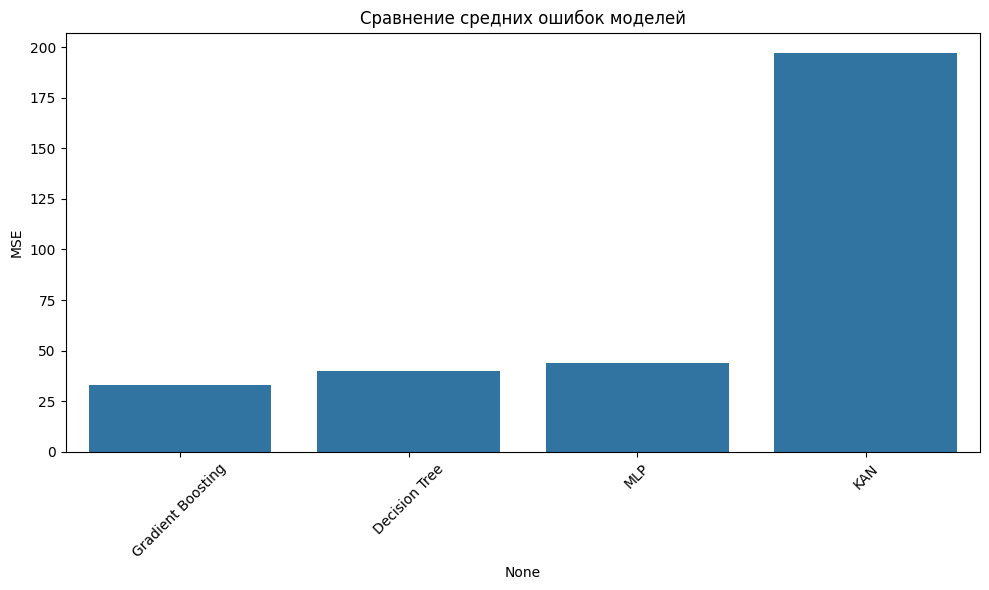

In [30]:
# Рассчитаем средние ошибки для каждой модели и ранжируем их
mean_errors = errors_df.mean().sort_values()
print("Средние ошибки моделей (по возрастанию):")
for model, error in mean_errors.items():
    print(f"{model}: {error:.6f}")

# Визуализация средних ошибок
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_errors.index, y=mean_errors.values)
plt.title('Сравнение средних ошибок моделей')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Выводы

1. Тест Фридмана показывает, есть ли статистически значимые различия между всеми моделями в целом.

2. Тест Неменьи (post-hoc) определяет, между какими конкретно парами моделей существуют значимые различия.

3. Сравнение средних ошибок позволяет ранжировать модели по точности и выбрать лучшую для данной задачи.

Эти статистические тесты помогают обосновать выбор модели не только на основе средних показателей ошибок, но и с учетом статистической значимости различий между моделями.